## Импортируем библиотеки

In [ ]:
!pip install tensorflow_datasets
# pip install nltk
# pip install torchvision
# conda install -c conda-forge wandb
# !pip install wandb -qU

In [1]:
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import nltk
import cv2
import matplotlib.pyplot as plt
import random
import math
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T

In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nataliakamushkina (science). Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project = "VQA_CLEVR")

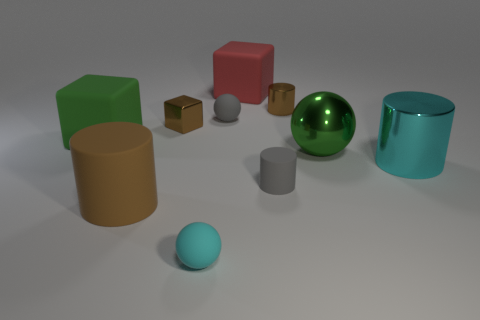

In [4]:
from IPython.display import Image

Image(filename = r'C:\\Users\\natal\\Downloads\\CLEVR_v1.0\\CLEVR_v1.0\\images\\train\\CLEVR_train_001404.png')

# Загрузка данных

#### Обучающая выборка

In [5]:
trainData = []

# изображения
with open('C://Users//natal//Downloads//CLEVR_v1.0//CLEVR_v1.0//questions/CLEVR_train_questions.json') as f:
    data = json.load(f)
    for K in range(20):
        i = data['questions'][random.randrange(20, 5000, 3)]
        tmp = []
        
# вопросы с ответами
        for path in glob.glob('C://Users//natal//Downloads//CLEVR_v1.0//CLEVR_v1.0//images//train//'+i['image_filename']): 
            tmp.append(path)
        tmp.append(i['question'])
        tmp.append(i['answer'])
        trainData.append(tmp)

In [6]:
labels = ['Путь к файлу','Вопрос','Ответ']

train_dataframe = pd.DataFrame.from_records(trainData, columns = labels)

In [7]:
train_dataframe.head(3)

,Путь к файлу,Вопрос,Ответ
0,C://Users//natal//Downloads//CLEVR_v1.0//CLEVR...,What number of other things are there of the s...,1
1,C://Users//natal//Downloads//CLEVR_v1.0//CLEVR...,How many things are large balls or cubes in fr...,3
2,C://Users//natal//Downloads//CLEVR_v1.0//CLEVR...,Are there any green metal objects of the same ...,yes


#### Валидационная выборка  

In [8]:
validationData = []

# изображения
with open('C://Users//natal//Downloads//CLEVR_v1.0//CLEVR_v1.0//questions//CLEVR_val_questions.json') as f:
    data = json.load(f)
    for k in range(20):
        i = data['questions'][random.randrange(20, 5000, 3)]
        tmp = []

# вопросы с ответами
        for path in glob.glob('C://Users//natal//Downloads//CLEVR_v1.0//CLEVR_v1.0//images//val//'+i['image_filename']): 
            tmp.append(path)
        tmp.append(i['question'])
        tmp.append(i['answer'])
        validationData.append(tmp)


In [9]:
labels = ['Путь к файлу','Вопрос','Ответ']

validation_Data = pd.DataFrame.from_records(validationData, columns = labels)

In [10]:
validation_Data.head(3)

,Путь к файлу,Вопрос,Ответ
0,C://Users//natal//Downloads//CLEVR_v1.0//CLEVR...,What is the color of the cube behind the big r...,cyan
1,C://Users//natal//Downloads//CLEVR_v1.0//CLEVR...,There is a ball that is both in front of the l...,metal
2,C://Users//natal//Downloads//CLEVR_v1.0//CLEVR...,How many objects are either tiny blue objects ...,3


## Кодирование изображения

In [17]:
imgtest = tf.io.read_file(validation_Data.iloc[0]['Путь к файлу'])

In [18]:
IMG_SIZE = (200, 200)
imgtest = tf.image.decode_jpeg(imgtest,channels = 3)
imgtest = tf.image.resize(imgtest,IMG_SIZE)

In [19]:
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))

In [20]:
BATCH_SIZE = 50
IMG_SIZE = (200,200)


def preprocess(ip,ans):
    img, ques = ip
    
    # изображения
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img,IMG_SIZE)
    img = tf.math.divide(img, 255)
 
    # вопросы
    ques = tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])
    
    # ответы
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans

In [21]:
def create_pipeline(dataframe):
    raw_df = tf.data.Dataset.from_tensor_slices(((dataframe['Путь к файлу'],dataframe['Вопрос']),dataframe['Ответ']))
    df = raw_df.map(preprocess)
    df = df.batch(BATCH_SIZE)
    
    return df

In [22]:
# подготавливаем данные
train_dataset = create_pipeline(train_dataframe)
validation_dataset = create_pipeline(validation_Data)

## Кодирование текста

In [23]:
# Создание кодировщика и функции для предварительной обработки текстовых данных 
voc = set()

tokenizer = tfds.deprecated.text.Tokenizer()

for i in validation_Data['Вопрос']:
    voc.update(tokenizer.tokenize(i))
for i in train_dataframe['Вопрос']:
    voc.update(tokenizer.tokenize(i))
    
for i in validation_Data['Ответ']:
    voc.update(tokenizer.tokenize(i))
for i in train_dataframe['Ответ']:
    voc.update(tokenizer.tokenize(i))
    
encoder = tfds.deprecated.text.TokenTextEncoder(voc)

## Модель CNN для обработки изображений

In [24]:
CNN_Input = tf.keras.layers.Input(shape=(200,200,3),name = 'image_input')

mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (200,200,3), 
                                                           alpha = 1.0, 
                                                           include_top = False,
                                                           weights = 'imagenet', 
                                                           input_tensor = CNN_Input)

CNN_model = tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(mobilenetv2)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())

## Модель RNN для обработки текста

In [46]:
RNN_model = tf.keras.models.Sequential()

RNN_Input = tf.keras.layers.Input(shape = (50), name = 'text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(voc) + 1,256))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))

In [47]:
concat = tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out = tf.keras.layers.Dense(len(voc), activation = 'softmax', name = 'output')(concat)

model = tf.keras.Model(inputs=[CNN_Input,RNN_Input], outputs = dense_out)
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 256)      21504       ['text_input[0][0]']             
                                                                                                  
 image_input (InputLayer)       [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 50, 512)     1050624     ['embedding_2[0][0]']      

# Обучение модели

In [48]:
def scheduler(epoch):
    if epoch < 1:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (1 - epoch))

In [49]:
LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

csv_callback=tf.keras.callbacks.CSVLogger(
    "Train_Param.csv", separator=',', append=False
)
teste = 1
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
epoch = 0

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = 'weights.{epoch:02d}.ckpt', verbose = 1, save_weights_only = True, save_freq = 1000 * BATCH_SIZE) # сохраняем веса

model.save_weights(checkpoint_path.format(epoch=0,val_loss=0))

with tf.device("/GPU:0"):
    history =  model.fit(train_dataset, validation_data = validation_dataset,
              #callbacks = [csv_callback,LRS,cp_callback],
              epochs=2, callbacks = [WandbCallback()])

Epoch 1/2
1/1 [==============================] - 32s 32s/step - loss: 4.7774 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 5.5667 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.7190 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.0778 - val_sparse_categorical_accuracy: 0.1000


In [50]:
hstr = pd.DataFrame(history.history)
hstr['epoch'] = history.epoch
history.history
hstr

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,epoch
0,4.777412,0.0,5.566708,0.0,0
1,0.719030,1.0,5.077785,0.1,1
